In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from oneibl import one
from export_funs import trialinfo_to_df
from prior_funcs import fit_sess_psytrack

%matplotlib inline
one = one.ONE(offline=True)

SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

session_id = '259927fd-7563-4b03-bc5d-17b4d0fa7a55'
trialsdf = trialinfo_to_df(session_id, maxlen=2.)
wts, stds = fit_sess_psytrack(session_id, maxlength=2., as_df=True)
trialsdf = pd.concat((trialsdf, wts['bias']), axis=1)
bias_next = np.roll(trialsdf['bias'], -1)
bias_next = pd.Series(bias_next, index=trialsdf['bias'].index)[:-1]
trialsdf['bias_next'] = bias_next
spk_times = one.load(session_id, dataset_types=['spikes.times'], offline=True)[0]
spk_clu = one.load(session_id, dataset_types=['spikes.clusters'], offline=True)[0]

Connected to https://alyx.internationalbrainlab.org as berk.gercek


In [2]:
import ipywidgets as iw
from brainbox.plot import peri_event_time_histogram
from brainbox.singlecell import calculate_peths

BINSIZE = 0.005

fitdata = np.load('/home/berk/Documents/Projects/prior-localization/rcos_synthetic_data_multifits.p', allow_pickle=True)

cells = list(fitdata.keys())
kernels = np.array(['stim', 'feedback', 'wheel'])
combs = fitdata[0].keys()
combnames = {np.array2string(kernels[list(c)]): c for c in combs}


@iw.interact
def plot_fits(cell=cells, combination=combnames.keys()):
    left_t = trialsdf[np.isfinite(trialsdf.contrastLeft)].stimOn_times
    fdbk = trialsdf[np.isfinite(trialsdf.contrastLeft)].feedback_times
    left_rate, _ = calculate_peths(spk_times, spk_clu, [cell], left_t, pre_time=0,
                                   post_time=0.6, bin_size=BINSIZE)
    left_rate.means = left_rate.means - left_rate.means.min()
    left_rate = left_rate.means.flatten()
    fdbk_rate, _ = calculate_peths(spk_times, spk_clu, [cell], fdbk, pre_time=0,
                                   post_time=0.6, bin_size=BINSIZE)
    fdbk_rate.means = fdbk_rate.means - fdbk_rate.means.min()
    fdbk_rate = fdbk_rate.means.flatten()
    wheelkern = np.exp(-0.5 * ((np.linspace(0, 0.4, int(0.4 / BINSIZE)) - 0.3) / 0.05)**2)
    logpeak = np.log(np.max([np.max(left_rate), np.max(fdbk_rate)]))
    wheelkern = wheelkern / np.max(wheelkern) * logpeak
    tstamps_l = np.linspace(0, 0.6, int(0.6 / BINSIZE))
    tstamps_s = np.linspace(0, 0.4, int(0.4 / BINSIZE))
    
    comb = combnames[combination]
    ncols = sum(comb)
    size = (8, 4 * (2 + ncols / 3))
    fig, ax = plt.subplots(4, ncols, figsize=size)
    if ncols == 1:
        ax = ax.reshape(-1, 1)
    i = 0
    if comb[0] is True:
        ax[0, i].plot(tstamps_l, left_rate)
        ax[0, i].set_xlim([0, 0.6])
        ax[0, i].set_title('Original stim on PSTH')
        for j, N in enumerate(fitdata[cell][comb].keys()):
            ax[j + 1, i].plot(tstamps_l, left_rate, c='k', label='original', lw=3)
            for trace in fitdata[cell][comb][N]:
                ax[j + 1, i].plot((1 / 0.02) * np.exp(trace[i + 1] + trace[0]), color='b', alpha=0.25)
            ax[j + 1, i].set_title(f"{N} trials")
            ax[j + 1, i].set_xlim([0, 0.6])
#             ax[j + 1, i].legend()
        i += 1
    if comb[1] is True:
        ax[0, i].plot(tstamps_l, fdbk_rate)
        ax[0, i].set_xlim([0, 0.6])
        ax[0, i].set_title('Original feedback PSTH')
        for j, N in enumerate(fitdata[cell][comb].keys()):
            ax[j + 1, i].plot(tstamps_l, fdbk_rate, c='k', label='original', lw=3)
            for trace in fitdata[cell][comb][N]:
                ax[j + 1, i].plot((1 / 0.02) * np.exp(trace[i + 1] + trace[0]), color='b', alpha=0.25)
            ax[j + 1, i].set_title(f"{N} trials")
            ax[j + 1, i].set_xlim([0, 0.6])
#             ax[j + 1, i].legend()
        i += 1
    if comb[2] is True:
        ax[0, i].plot(tstamps_s - 0.4, wheelkern)
        ax[0, i].set_title('Original wheel kernel')
        for j, N in enumerate(fitdata[cell][comb].keys()):
            ax[j + 1, i].plot(tstamps_s - 0.4, wheelkern, c='k', label='original', lw=3)
            for trace in fitdata[cell][comb][N]:
                ax[j + 1, i].plot((1 / np.log(1 / 0.02)) * trace[i + 1], color='b', alpha=0.25)  # Why the fuck is it always 1/4????
            ax[j + 1, i].set_title(f"{N} trials")
#             ax[j + 1, i].legend()
    plt.tight_layout()

interactive(children=(Dropdown(description='cell', options=(0, 1, 2, 9, 15, 16, 20, 26, 29, 30), value=0), Dro…

Text(0, 0.5, 'Weight')

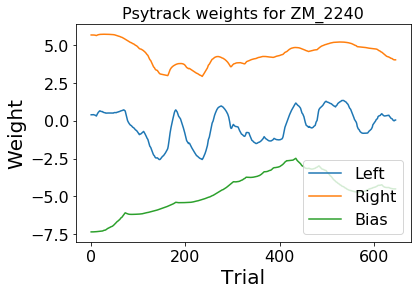

In [10]:
plt.plot(wts.left, label='Left')
plt.plot(wts.right, label='Right')
plt.plot(wts.bias, label='Bias')
plt.legend()
plt.title('Psytrack weights for ZM_2240')
plt.xlabel('Trial')
plt.ylabel('Weight')